# Building MLP Part 2
- Video: [Andrej Karpathy - Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I&t=4076s)
- MLP paper: [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


In [1]:
# core libraries
import torch
import torch.nn.functional as F

import numpy as np
import pandas as pd
import pyarrow as pa
import random
import seaborn as sns
import matplotlib.pyplot as plt

# matpolitlib config
%matplotlib inline

In [2]:
# read all the words
words = open('./source/names.txt', 'r').read().splitlines()

### Character encoder

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

### Build the dataset

In [4]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
      context = [0] * block_size
      for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# split the data in three 1. train, 2. development, 3.test
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Parameters update
- 200 nodes in hidden layer
- scale up the embedding size from 2 to 10

In [5]:
# initial parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]

In [6]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [7]:
# the parameter gradients must be reset in Torch
for p in parameters:
    p.requires_grad = True

### Optimize Neural Network

In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward
    emb = C[Xb]                        # embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # outer layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward
    for p in parameters:
        p.grad = None 
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8598
  20000/ 200000: 2.5249
  30000/ 200000: 2.8522
  40000/ 200000: 2.0585
  50000/ 200000: 2.5718
  60000/ 200000: 2.3764
  70000/ 200000: 2.1211
  80000/ 200000: 2.2893
  90000/ 200000: 2.3247
 100000/ 200000: 2.0574
 110000/ 200000: 2.4674
 120000/ 200000: 1.9108
 130000/ 200000: 2.4755
 140000/ 200000: 2.1971
 150000/ 200000: 2.1689
 160000/ 200000: 2.1055
 170000/ 200000: 1.8050
 180000/ 200000: 2.0539
 190000/ 200000: 1.8716


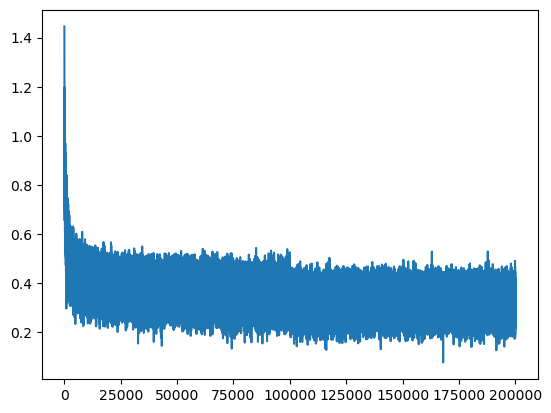

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    # forward
    emb = C[x]                        # embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # outer layer
    loss = F.cross_entropy(logits, y)  # loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.127263069152832
val 2.1711132526397705


## Results

In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) 
        logits = h @ W2 + b2
        # sofrmax get the probabilities
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nah.
yam.
ren.
rucendrae.
cadee.
daelin.
shy.
jen.
eden.
estanaraelyn.
malara.
noshubergihamiest.
jair.
jenipanthona.
ubelleder.
yarue.
els.
